## Data Exploration

In [1]:
import pandas as pd

df = pd.read_csv('./data/SC_NC_combined.csv')

In [2]:
# Drop the 'state column' since that won't be used for the classification
df.drop(columns='state', inplace=True)

In [3]:
df

,year,act,jim_crow
0,1879,AN ACT to PREVENT AND PunisH THE INTERMARRYING...,1
1,1879,Section 1.,0
2,1879,Be it enacted by the Senate and House of Repre...,1
3,1879,Sec. 2.,0
4,1879,Any person who shall violate the first Section...,1
...,...,...,...
6469,1955,In all cases in which a municipality has a col...,1
6470,1955,That appropriations made to the Oxford Colored...,1
6471,1959,That appropriations made to the Oxford Colored...,1
6472,1961,"G. S. -, as the same presently appears in the ...",1


<Axes: xlabel='jim_crow', ylabel='count'>

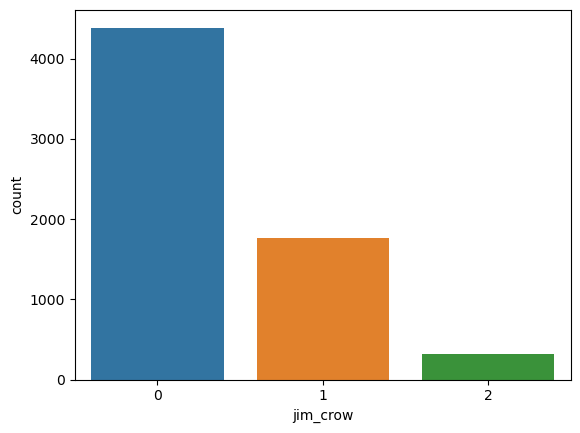

In [4]:
from seaborn import countplot

# Plot the distribution of the target
countplot(x=df['jim_crow'])

In [5]:
# Check for missing values
df.isnull().sum().sum()

0

In [6]:
# Split data
features = df[['year', 'act']]
target = df['jim_crow']

In [7]:
print(features.shape, target.shape)

(6474, 2) (6474,)


In [8]:
features

,year,act
0,1879,AN ACT to PREVENT AND PunisH THE INTERMARRYING...
1,1879,Section 1.
2,1879,Be it enacted by the Senate and House of Repre...
3,1879,Sec. 2.
4,1879,Any person who shall violate the first Section...
...,...,...
6469,1955,In all cases in which a municipality has a col...
6470,1955,That appropriations made to the Oxford Colored...
6471,1959,That appropriations made to the Oxford Colored...
6472,1961,"G. S. -, as the same presently appears in the ..."


<br>

## Feature Extraction

In [9]:
# Since the dataset in a string format, it needs to be converted to something numeric.
# Apply TFIDFVectorizer for the acts
# Apply Dummy Encoding for the years (using OneHotEncoder)

# Combine the outputs of TFIDFVectorizer and Dummy Encoding using ColumnTransformer
# which returns a sparse matrix

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# columnTransformer = ColumnTransformer(
#     [('ohe', OneHotEncoder(dtype='int', drop='first', handle_unknown='ignore'), ['year']),
#      ('tfidf', TfidfVectorizer(decode_error='ignore', stop_words=None, max_features=100000), 'act')],
#     remainder='drop')

columnTransformer = ColumnTransformer(
    [('ohe', OneHotEncoder(dtype='int', drop='first', handle_unknown='ignore'), [0]),
     ('tfidf', TfidfVectorizer(decode_error='ignore', stop_words=None, max_features=100000), 1)],
    remainder='drop')

vector_transformer = columnTransformer.fit(features)
vectorized_df = vector_transformer.transform(features)

In [10]:
# target = target.to_frame()

In [11]:
vectorized_df

<6474x11116 sparse matrix of type '<class 'numpy.float64'>'
	with 235305 stored elements in Compressed Sparse Row format>

<br>

## Using SMOTE to Fix Imbalanced Classes

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(vectorized_df, target)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10528, 11116) (10528,)
(2633, 11116) (2633,)


<br>

## Models

### XGBoost

In [15]:
import xgboost as xgb

xgbC = xgb.XGBClassifier(objective='multi:softprob', random_state=13)
xgbC.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [16]:
xgbC_pred = xgbC.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy %s' % accuracy_score(xgbC_pred, y_test))
print(classification_report(y_test, xgbC_pred))

Accuracy 0.9544246107102164
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       868
           1       0.97      0.95      0.96       890
           2       0.96      0.96      0.96       875

    accuracy                           0.95      2633
   macro avg       0.95      0.95      0.95      2633
weighted avg       0.95      0.95      0.95      2633



<br>

### SGD

In [18]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)

SGDClassifier()

In [19]:
sgd_pred = sgd.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy %s' % accuracy_score(sgd_pred, y_test))
print(classification_report(y_test, sgd_pred))

Accuracy 0.9472085074060007
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       868
           1       0.95      0.95      0.95       890
           2       0.93      0.99      0.96       875

    accuracy                           0.95      2633
   macro avg       0.95      0.95      0.95      2633
weighted avg       0.95      0.95      0.95      2633

